# **Step 1: Fetching Movie Data from the TMDB API**

In this section, I connect to the TMDB API and retrieve metadata for a selected list of movie IDs.
The API returns a wide range of movie information, including:

- **Title**, **overview**, and **release date**
- **Credits**: Cast and crew details
- **Production companies**, **genres**, and **production countries**
- **Budget**, **revenue**, **runtime**, and other numerical attributes
- **Popularity**, **vote count**, and **vote average**

Each API response is stored as a Python dictionary, and once all movie data is collected, the records are converted into a Pandas DataFrame.
This provides a structured table that we will clean and analyze in the next steps.

In [3]:
import requests
import pandas as pd
import numpy as np
import ast


tmdb_api_key = "d28817cbe53083fce1c92e62103d08ac"

movie_id = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 321612, 260513]

# Initialize an empty list to store movie data
movies = []

# Loop through each movie_id to fetch data
for m_id in movie_id:
    url = f"https://api.themoviedb.org/3/movie/{m_id}?api_key={tmdb_api_key}&append_to_response=credits"

    success = False
    attempts = 0
    max_attempts = 3 

    while not success and attempts < max_attempts:
        try:
            response = requests.get(url)
            attempts += 1

            if response.status_code == 200:
                movies.append(response.json())
                success = True
            elif response.status_code == 404:    # Movie does not exist 
                
                print(f"Movie ID {m_id} not found (404). Skipping.")
                break
            else:
                # Other errors: try again
                print(f"Attempt {attempts} for ID {m_id} failed (status {response.status_code}). Retrying...")
                time.sleep(1)

        except requests.exceptions.RequestException as e:
            # Network issues
            attempts += 1
            print(f"Network error on ID {m_id}: {e}. Retrying...")
            time.sleep(1)

    if not success and attempts >= max_attempts:
        print(f"Failed to fetch movie ID {m_id} after {max_attempts} attempts. Skipped.")

df = pd.DataFrame(movies)

df.head()


Movie ID 0 not found (404). Skipping.


,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits
0,False,/9wXPKruA6bWYk2co5ix6fH59Qr8.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534,tt4154796,[US],en,...,2799439100,181,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Avenge the fallen.,Avengers: Endgame,False,8.237,26971,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,False,/7JNzw1tSZZEgsBw6lu0VfO2X2Ef.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995,tt0499549,[US],en,...,2923706026,162,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Enter the world of Pandora.,Avatar,False,7.594,32867,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
2,False,/8BTsTfln4jlQrLXUBquXJ0ASQy9.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.starwars.com/films/star-wars-episod...,140607,tt2488496,[US],en,...,2068223624,136,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.255,20104,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
3,False,/mDfJG3LC3Dqb67AZ52x3Z0jU0uB.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/avengers-infinit...,299536,tt4154756,[US],en,...,2052415039,149,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Destiny arrives all the same.,Avengers: Infinity War,False,8.235,31184,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
4,False,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,None,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.paramountmovies.com/movies/titanic,597,tt0120338,[US],en,...,2264162353,194,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Nothing on earth could come between them.,Titanic,False,7.903,26518,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


# **Step 2: Data Cleaning and Preprocessing**

The raw API data contains nested JSON objects, unnecessary columns, missing values, and inconsistent formats.
This step focuses on transforming the raw API output into a clean analytical dataset.

## **2.1 Removing Irrelevant Columns**

Columns such as **adult**, **video**, **homepage**, **imdb_id**, and **original_title**, **postcard_path**, **backdrop_path** do not contribute to our analysis and are therefore removed to reduce clutter and improve readability.

## **2.2 Flattening JSON-Like Columns**

Several fields returned by the API (e.g., genres, spoken_languages, production_companies) are lists of dictionaries.
To make them usable for filtering and grouping, we extract only the meaningful textual fields, typically "name", and convert them into a single string separated by "|".

I perform this for:

- **genres**
- **production_countries**
- **production_companies**
- **spoken_languages**
- **belongs_to_collection** (extract collection name only)

This step turns complex nested structures into simple, human-readable columns.

## **2.3 Converting Data Types**

Numeric columns such as **budget**, **revenue**, **popularity**, **vote_count**, and **runtime** are converted into numeric types.
The **release_date** field is converted into a proper datetime type.

Invalid or missing values are coerced into NaN.

## **2.4 Handling Incorrect or Missing Values**

Budget and revenue fields sometimes appear as zero, which is unrealistic.
To standardize the data:

- **budget** and **revenue** are converted into millions of USD (**budget_musd** and **revenue_musd**)
- Movies with invalid or zero budgets are excluded from ROI calculations
- Placeholder text such as "No Data" in textual fields is replaced with NaN

I also compute important derived metrics:

- **Profit**: profit_musd = revenue_musd - budget_musd
- **ROI**: roi = revenue / budget (only valid for movies with non-zero budgets)

## **2.5 Removing Duplicates and Irrelevant Rows**

I drop:

- Duplicate rows
- Movies with missing titles or IDs
- Movies with too many missing values
- Any movie that is not in "Released" status

This ensures only valid, analyzable films remain.

## **2.6 Reordering Columns**

I arrange the columns in a cleaner, logical order so the dataset is easier to inspect and understand.

Finally, I reset the index.

In [4]:
columns_to_drop = ['adult', 'backdrop_path','homepage', 'imdb_id',  'original_title', 'video','poster_path']
df = df.drop(columns= columns_to_drop, errors = 'ignore')

def extract_names(cell):
    if isinstance(cell, list):
        return " | ".join([item.get('name', '') for item in cell])
    return np.nan
    
# Apply extraction
json_columns = ['genres', 'production_countries', 'production_companies', 'spoken_languages']

for col in json_columns:
    df[col] = df[col].apply(extract_names)

# belongs_to_collection needs only the collection name
df['belongs_to_collection'] = df['belongs_to_collection'].apply(
    lambda x: x.get('name') if isinstance(x, dict) else np.nan
)

#converts datatype
df['release_date'] = pd.to_datetime(df['release_date'], errors = 'coerce')

number_cols = ['id', 'budget', 'revenue', 'popularity', 'vote_count', 'vote_average', 'runtime']
for col in number_cols:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')

# Inspects extracted columns
columns_to_inspect = [
    'genres',
    'belongs_to_collection',
    'production_companies',
    'production_countries',
    'spoken_languages',
    'original_language'
]

for col in columns_to_inspect:
    print(f"\n VALUE COUNTS FOR: {col} ")
    print(df[col].value_counts(dropna=False))

# Fixes invalid values
df.loc[df['budget']==0, 'budget'] = np.nan   
df.loc[df['revenue'] == 0, 'revenue'] = np.nan
df.loc[df['runtime'] == 0, 'runtime'] = np.nan    
df.loc[df['vote_count'] == 0, 'vote_average'] = np.nan


# converts budget to millions
df['budget_musd'] = df['budget'] / 1_000_000
df['revenue_musd'] = df['revenue'] / 1_000_000

# Clean text fields
text_fields = ['overview', 'tagline']

for col in text_fields:
    df[col] = df[col].replace(['', ' ', 'No Data', 'N/A'], np.nan)

# Remove duplicates
df = df.drop_duplicates(subset=['id'], keep='first')


# Keep rows with at least 10 non-missing values
df = df[df.count(axis=1) >= 10]

# Keep only released movies
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], errors='ignore')


#Credits Column
# Parse credits JSON safely
def safe_parse(x):
    if isinstance(x, dict):       # API returns dict → keep it
        return x
    if isinstance(x, str):        # CSV returns string → parse it
        try:
            return ast.literal_eval(x)
        except:
            return {}
    return {}

df['credits'] = df['credits'].apply(safe_parse)

# Extract Cast List
def extract_cast(credits):
    try:
        cast_list = credits.get("cast", [])
        # return only names
        return [c.get("name") for c in cast_list if "name" in c]
    except:
        return []

df['cast'] = df['credits'].apply(extract_cast)
df['cast_size'] = df['cast'].apply(len)

# Extract Director from Crew
def extract_director(credits):
    try:
        crew_list = credits.get("crew", [])
        for c in crew_list:
            # find the person whose job = Director
            if c.get("job") == "Director":
                return c.get("name")
        return None
    except:
        return None

df['director'] = df['credits'].apply(extract_director)

# Crew size
def extract_crew_size(credits):
    try:
        return len(credits.get("crew", []))
    except:
        return 0

df['crew_size'] = df['credits'].apply(extract_crew_size)



# STEP 2.9 — Reorder columns
final_order = [
    'id',
    'title',
    'tagline',
    'overview',
    'release_date',

    'genres',
    'belongs_to_collection',
    'original_language',
    'spoken_languages',

    'production_companies',
    'production_countries',

    'budget_musd',
    'revenue_musd',

    'runtime',
    'popularity',
    'vote_count',
    'vote_average',
    
    'cast',
    'cast_size',
    'director',
    'crew_size'
]


# Only keep columns that actually exist
final_order = [c for c in final_order if c in df.columns]

df = df[final_order]

# drop original huge credits column
# df = df.drop(columns=['credits'])

# STEP 2.10 — Reset index
df.reset_index(drop=True, inplace=True)



 VALUE COUNTS FOR: genres 
genres
Adventure | Action | Science Fiction                 3
Action | Adventure | Science Fiction | Thriller      2
Action | Adventure | Science Fiction                 2
Adventure | Science Fiction | Action                 1
Action | Adventure | Fantasy | Science Fiction       1
Drama | Romance                                      1
Adventure | Drama | Family | Animation               1
Science Fiction | Action | Adventure                 1
Action | Crime | Thriller                            1
Adventure | Fantasy                                  1
Family | Animation | Adventure | Comedy | Fantasy    1
Animation | Family | Adventure | Fantasy             1
Family | Fantasy | Romance                           1
Action | Adventure | Animation | Family              1
Name: count, dtype: int64

 VALUE COUNTS FOR: belongs_to_collection 
belongs_to_collection
The Avengers Collection                4
Star Wars Collection                   2
NaN                   

In [5]:
# Derived KPIs and ranking UDF
from typing import Optional

# Derived KPIs: profit_musd and roi 
df['profit_musd'] = df['revenue_musd'] - df['budget_musd']

# ROI: avoid divide-by-zero; only compute when budget_musd > 0 and budget_musd is not null
df['roi'] = np.where(
    (df['budget_musd'].notna()) & (df['budget_musd'] > 0),
    df['revenue_musd'] / df['budget_musd'],
    np.nan
)

# 3) Ranking UDF 
def rank_movies(df, score_col, top_n=10, ascending=False,
                min_budget=None, min_votes=None):
    
    temp = df.copy()

    if min_budget is not None:   
        temp = temp[temp['budget_musd'].ge(min_budget)]
        
    if min_votes is not None:
        temp = temp[temp['vote_count'].ge(min_votes)]
    
    temp = temp[temp[score_col].notna()]
    temp = temp.sort_values(score_col, ascending=ascending).head(top_n)

    cols = ['title', 'release_date', 'budget_musd', 'revenue_musd',
            'profit_musd', 'roi', 'vote_count', 'vote_average', 'popularity']
    cols = [c for c in cols if c in temp.columns]

    return temp[cols]

# **Step 3: KPI Implementation and Analysis**

In this section, I define financial and popularity-based KPIs (Key Performance Indicators) to evaluate movie performance.

## **3.1 Ranking Function for KPIs**

To avoid repetitive code, we define a general-purpose ranking function:
rank_movies(df, column, top_n=10, ascending=False)




This function:

- Sorts the dataset based on any metric
- Allows top or bottom rankings
- Automatically drops missing values
- Returns a clean table with key movie information

Using a single function keeps the code modular and easier to maintain.

## **3.2 KPI-Based Rankings**

I computed ranked lists for:

- **Highest Revenue** movies
- **Highest Budget** productions
- **Highest Profit** (Revenue - Budget)
- **Lowest Profit** (Revenue - Budget)
- **Highest ROI** (Revenue / Budget) for movies with Budget ≥ $10M
- **Lowest ROI** for movies with Budget ≥ $10M
- **Most Voted** Movies
- **Highest Rated** Movies (with ≥ 10 votes)
- **Lowest Rated** Movies (with ≥ 10 votes)
- **Most Popular** Movies

These KPIs help us identify the best and worst performing movies across financial, rating, and popularity metrics.

## **3.3 Advanced Filtering and Search Queries**

I used Pandas filtering to answer custom movie searches:

- Best-rated Science Fiction Action movies starring Bruce Willis
- Movies starring Uma Thurman

These queries demonstrate advanced slicing and searching within the dataset.

## **3.4 Franchise vs Standalone Movie Analysis**

We compare movies belonging to a franchise (collection) against those that are standalone.

This helps us understand whether franchises tend to perform better in key KPIs.

## **3.5 Most Successful Movie Franchises**

I grouped movies by **belongs_to_collection** and calculate:

- Number of movies in the franchise
- Total and average budget
- Total and average revenue
- Average rating

This shows which franchises are the most valuable and consistent.

## **3.6 Most Successful Directors**

I grouped by **director** and compute:

- Total number of movies directed
- Total revenue generated
- Mean rating

This helps identify directors who are commercially and critically successful.

In [6]:

# TOP/BOTTOM MOVIE KPI TABLES


print("\n TOP 10 Highest Revenue")
display(rank_movies(df, 'revenue_musd', top_n=10))

print("\n TOP 10 Highest Budget")
display(rank_movies(df, 'budget_musd', top_n=10))

print("\n TOP 10 Highest Profit")
display(rank_movies(df, 'profit_musd', top_n=10))

print("\n BOTTOM 10 Lowest Profit")
display(rank_movies(df, 'profit_musd', ascending=True, top_n=10))

print("\n TOP 10 Highest ROI (Budget >= 10M)")
display(rank_movies(df, 'roi', min_budget=10, top_n=10))

print("\n BOTTOM 10 Lowest ROI (Budget >= 10M)")
display(rank_movies(df, 'roi', ascending=True, min_budget=10, top_n=10))

print("\n TOP 10 Most Voted Movies")
display(rank_movies(df, 'vote_count', top_n=10))

print("\n TOP 10 Highest Rated Movies (Votes >= 10)")
display(rank_movies(df, 'vote_average', min_votes=10, top_n=10))

print("\n BOTTOM 10 Lowest Rated Movies (Votes >= 10)")
display(rank_movies(df, 'vote_average', ascending=True, min_votes=10, top_n=10))

print("\n TOP 10 Most Popular Movies")
display(rank_movies(df, 'popularity', top_n=10))



 TOP 10 Highest Revenue


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
5,Jurassic World,2015-06-06,150.0,1671.537444,1521.537444,11.143583,21126,6.699,9.8352
6,The Lion King,2019-07-12,260.0,1662.020819,1402.020819,6.392388,10571,7.102,8.6660
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
8,Furious 7,2015-04-01,190.0,1515.400000,1325.400000,7.975789,11033,7.200,29.0959
13,Frozen II,2019-11-20,150.0,1453.683476,1303.683476,9.691223,10073,7.241,9.4454



 TOP 10 Highest Budget


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
12,Star Wars: The Last Jedi,2017-12-13,300.0,1332.698830,1032.698830,4.442329,15927,6.800,5.8878
6,The Lion King,2019-07-12,260.0,1662.020819,1402.020819,6.392388,10571,7.102,8.6660
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
10,Black Panther,2018-02-13,200.0,1349.926083,1149.926083,6.749630,22976,7.366,8.2880
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381



 TOP 10 Highest Profit


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
5,Jurassic World,2015-06-06,150.0,1671.537444,1521.537444,11.143583,21126,6.699,9.8352
6,The Lion King,2019-07-12,260.0,1662.020819,1402.020819,6.392388,10571,7.102,8.6660
8,Furious 7,2015-04-01,190.0,1515.400000,1325.400000,7.975789,11033,7.200,29.0959
13,Frozen II,2019-11-20,150.0,1453.683476,1303.683476,9.691223,10073,7.241,9.4454
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896



 BOTTOM 10 Lowest Profit


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
12,Star Wars: The Last Jedi,2017-12-13,300.0,1332.698830,1032.698830,4.442329,15927,6.800,5.8878
17,Incredibles 2,2018-06-14,200.0,1243.225667,1043.225667,6.216128,13370,7.455,8.7764
16,Beauty and the Beast,2017-03-16,160.0,1266.115964,1106.115964,7.913225,15833,6.969,11.1129
15,Frozen,2013-11-20,150.0,1274.219009,1124.219009,8.494793,17186,7.200,17.8150
14,Jurassic World: Fallen Kingdom,2018-06-06,170.0,1310.469037,1140.469037,7.708641,12413,6.537,8.2567
10,Black Panther,2018-02-13,200.0,1349.926083,1149.926083,6.749630,22976,7.366,8.2880
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382
11,Harry Potter and the Deathly Hallows: Part 2,2011-07-12,125.0,1341.511219,1216.511219,10.732090,21458,8.084,15.4339
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
13,Frozen II,2019-11-20,150.0,1453.683476,1303.683476,9.691223,10073,7.241,9.4454



 TOP 10 Highest ROI (Budget >= 10M)


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
5,Jurassic World,2015-06-06,150.0,1671.537444,1521.537444,11.143583,21126,6.699,9.8352
11,Harry Potter and the Deathly Hallows: Part 2,2011-07-12,125.0,1341.511219,1216.511219,10.732090,21458,8.084,15.4339
13,Frozen II,2019-11-20,150.0,1453.683476,1303.683476,9.691223,10073,7.241,9.4454
15,Frozen,2013-11-20,150.0,1274.219009,1124.219009,8.494793,17186,7.200,17.8150
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475
8,Furious 7,2015-04-01,190.0,1515.400000,1325.400000,7.975789,11033,7.200,29.0959
16,Beauty and the Beast,2017-03-16,160.0,1266.115964,1106.115964,7.913225,15833,6.969,11.1129
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290



 BOTTOM 10 Lowest ROI (Budget >= 10M)


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
12,Star Wars: The Last Jedi,2017-12-13,300.0,1332.698830,1032.698830,4.442329,15927,6.800,5.8878
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382
17,Incredibles 2,2018-06-14,200.0,1243.225667,1043.225667,6.216128,13370,7.455,8.7764
6,The Lion King,2019-07-12,260.0,1662.020819,1402.020819,6.392388,10571,7.102,8.6660
10,Black Panther,2018-02-13,200.0,1349.926083,1149.926083,6.749630,22976,7.366,8.2880
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
14,Jurassic World: Fallen Kingdom,2018-06-06,170.0,1310.469037,1140.469037,7.708641,12413,6.537,8.2567
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
16,Beauty and the Beast,2017-03-16,160.0,1266.115964,1106.115964,7.913225,15833,6.969,11.1129



 TOP 10 Most Voted Movies


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382
10,Black Panther,2018-02-13,200.0,1349.926083,1149.926083,6.749630,22976,7.366,8.2880
11,Harry Potter and the Deathly Hallows: Part 2,2011-07-12,125.0,1341.511219,1216.511219,10.732090,21458,8.084,15.4339
5,Jurassic World,2015-06-06,150.0,1671.537444,1521.537444,11.143583,21126,6.699,9.8352
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475



 TOP 10 Highest Rated Movies (Votes >= 10)


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
11,Harry Potter and the Deathly Hallows: Part 2,2011-07-12,125.0,1341.511219,1216.511219,10.732090,21458,8.084,15.4339
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
17,Incredibles 2,2018-06-14,200.0,1243.225667,1043.225667,6.216128,13370,7.455,8.7764
10,Black Panther,2018-02-13,200.0,1349.926083,1149.926083,6.749630,22976,7.366,8.2880
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475



 BOTTOM 10 Lowest Rated Movies (Votes >= 10)


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
14,Jurassic World: Fallen Kingdom,2018-06-06,170.0,1310.469037,1140.469037,7.708641,12413,6.537,8.2567
5,Jurassic World,2015-06-06,150.0,1671.537444,1521.537444,11.143583,21126,6.699,9.8352
12,Star Wars: The Last Jedi,2017-12-13,300.0,1332.698830,1032.698830,4.442329,15927,6.800,5.8878
16,Beauty and the Beast,2017-03-16,160.0,1266.115964,1106.115964,7.913225,15833,6.969,11.1129
6,The Lion King,2019-07-12,260.0,1662.020819,1402.020819,6.392388,10571,7.102,8.6660
8,Furious 7,2015-04-01,190.0,1515.400000,1325.400000,7.975789,11033,7.200,29.0959
15,Frozen,2013-11-20,150.0,1274.219009,1124.219009,8.494793,17186,7.200,17.8150
13,Frozen II,2019-11-20,150.0,1453.683476,1303.683476,9.691223,10073,7.241,9.4454
2,Star Wars: The Force Awakens,2015-12-15,245.0,2068.223624,1823.223624,8.441729,20104,7.255,7.1475
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382



 TOP 10 Most Popular Movies


,title,release_date,budget_musd,revenue_musd,profit_musd,roi,vote_count,vote_average,popularity
7,The Avengers,2012-04-25,220.0,1518.815515,1298.815515,6.903707,34300,7.869,45.1896
1,Avatar,2009-12-15,237.0,2923.706026,2686.706026,12.336312,32867,7.594,32.1020
8,Furious 7,2015-04-01,190.0,1515.400000,1325.400000,7.975789,11033,7.200,29.0959
4,Titanic,1997-11-18,200.0,2264.162353,2064.162353,11.320812,26518,7.903,26.9381
3,Avengers: Infinity War,2018-04-25,300.0,2052.415039,1752.415039,6.841383,31184,8.235,20.3123
15,Frozen,2013-11-20,150.0,1274.219009,1124.219009,8.494793,17186,7.200,17.8150
11,Harry Potter and the Deathly Hallows: Part 2,2011-07-12,125.0,1341.511219,1216.511219,10.732090,21458,8.084,15.4339
0,Avengers: Endgame,2019-04-24,356.0,2799.439100,2443.439100,7.863593,26971,8.237,14.3290
16,Beauty and the Beast,2017-03-16,160.0,1266.115964,1106.115964,7.913225,15833,6.969,11.1129
9,Avengers: Age of Ultron,2015-04-22,235.0,1405.403694,1170.403694,5.980441,23880,7.271,10.9382


In [7]:
search1 = df[
    df['genres'].str.contains('Science Fiction', case=False, na=False) &
    df['genres'].str.contains('Action', case=False, na=False) &
    df['cast'].str.contains('Bruce Willis', case=False, na=False)
].sort_values('vote_average', ascending=False)


In [8]:
search2 = df[
    df['cast'].str.contains('Uma Thurman', case=False, na=False) &
    df['director'].str.contains('Quentin Tarantino', case=False, na=False)
].sort_values('runtime', ascending=True)


In [9]:
print("Search 1 — Best-rated Sci-Fi Action movies starring Bruce Willis:")
display(search1[['title','release_date','genres','cast','vote_average','vote_count']])

Search 1 — Best-rated Sci-Fi Action movies starring Bruce Willis:


,title,release_date,genres,cast,vote_average,vote_count


In [10]:
print("Search 2 — Uma Thurman movies directed by Quentin Tarantino (shortest first):")
display(search2[['title','release_date','runtime','director','cast']])

Search 2 — Uma Thurman movies directed by Quentin Tarantino (shortest first):


,title,release_date,runtime,director,cast


In [11]:
franchise_stats = df[df['belongs_to_collection'].notna()].groupby('belongs_to_collection').agg(
    n_movies=('id','count'),
    total_budget_musd=('budget_musd','sum'),
    mean_budget_musd=('budget_musd','mean'),
    total_revenue_musd=('revenue_musd','sum'),
    mean_revenue_musd=('revenue_musd','mean'),
    mean_rating=('vote_average','mean')
).sort_values('total_revenue_musd', ascending=False)

display(franchise_stats.head(20))


,n_movies,total_budget_musd,mean_budget_musd,total_revenue_musd,mean_revenue_musd,mean_rating
belongs_to_collection,,,,,,
The Avengers Collection,4,1111.0,277.75,7776.073348,1944.018337,7.9030
Star Wars Collection,2,545.0,272.50,3400.922454,1700.461227,7.0275
Jurassic Park Collection,2,320.0,160.00,2982.006481,1491.003241,6.6180
Avatar Collection,1,237.0,237.00,2923.706026,2923.706026,7.5940
Frozen Collection,2,300.0,150.00,2727.902485,1363.951242,7.2205
The Lion King (Reboot) Collection,1,260.0,260.00,1662.020819,1662.020819,7.1020
The Fast and the Furious Collection,1,190.0,190.00,1515.400000,1515.400000,7.2000
Black Panther Collection,1,200.0,200.00,1349.926083,1349.926083,7.3660
Harry Potter Collection,1,125.0,125.00,1341.511219,1341.511219,8.0840


In [12]:
director_stats = df[df['director'].notna()].groupby('director').agg(
    n_movies=('id','count'),
    total_revenue_musd=('revenue_musd','sum'),
    mean_rating=('vote_average','mean')
).sort_values('total_revenue_musd', ascending=False)

display(director_stats.head(20))


,n_movies,total_revenue_musd,mean_rating
director,,,
James Cameron,2,5187.868379,7.7485
Joss Whedon,2,2924.219209,7.5700
Anthony Russo,1,2799.439100,8.2370
J.J. Abrams,1,2068.223624,7.2550
Joe Russo,1,2052.415039,8.2350
Colin Trevorrow,1,1671.537444,6.6990
Jon Favreau,1,1662.020819,7.1020
James Wan,1,1515.400000,7.2000
Jennifer Lee,1,1453.683476,7.2410


# Visualization






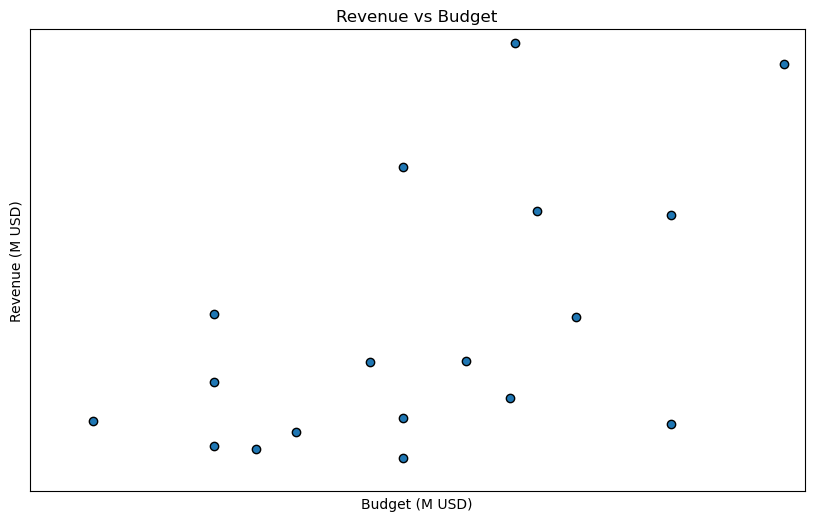

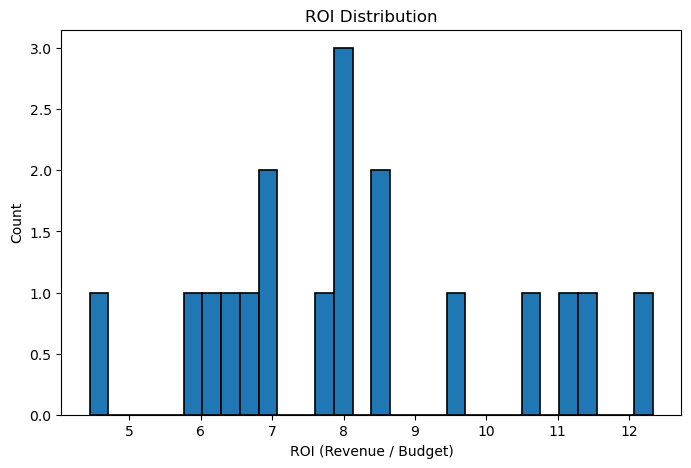

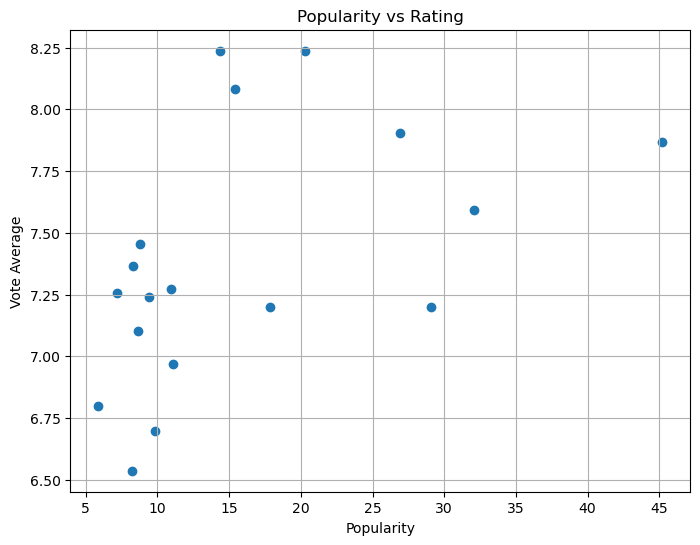

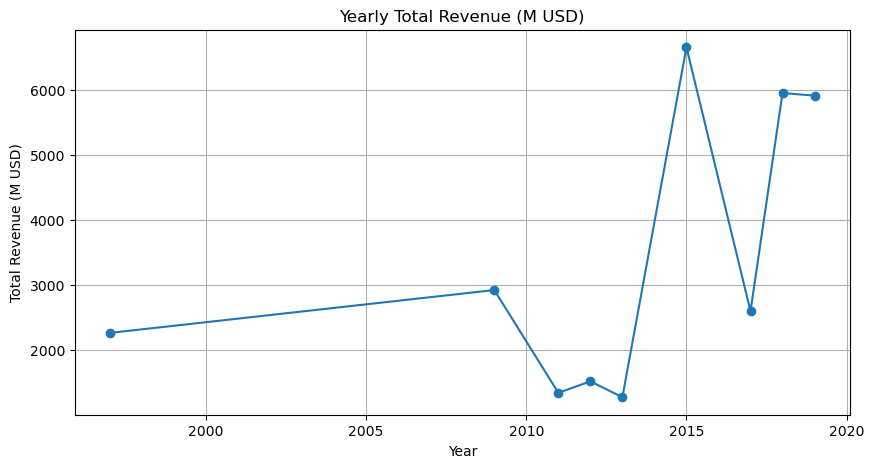

In [13]:
import matplotlib.pyplot as plt

# Revenue vs Budget scatter
plt.figure(figsize=(10,6))
plt.scatter(df['budget_musd'], df['revenue_musd'], edgecolor ='black')
plt.xlabel('Budget (M USD)')
plt.ylabel('Revenue (M USD)')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Revenue vs Budget')
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2) ROI distribution (histogram)
plt.figure(figsize=(8,5))
plt.hist(df['roi'].dropna(), bins=30, edgecolor='black', linewidth=1.2  )
plt.title('ROI Distribution')
plt.xlabel('ROI (Revenue / Budget)')
plt.ylabel('Count')
plt.show()

# 3) Popularity vs Rating scatter
plt.figure(figsize=(8,6))
plt.scatter(df['popularity'], df['vote_average'])
plt.xlabel('Popularity')
plt.ylabel('Vote Average')
plt.title('Popularity vs Rating')
plt.grid(True)
plt.show()

# 4) Yearly total revenue trend
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
yearly = df.groupby('year')['revenue_musd'].sum().dropna()

plt.figure(figsize=(10,5))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title('Yearly Total Revenue (M USD)')
plt.xlabel('Year')
plt.ylabel('Total Revenue (M USD)')
plt.grid(True)
plt.show()


In [14]:
df.head()

,id,title,tagline,overview,release_date,genres,belongs_to_collection,original_language,spoken_languages,production_companies,...,popularity,vote_count,vote_average,cast,cast_size,director,crew_size,profit_musd,roi,year
0,299534,Avengers: Endgame,Avenge the fallen.,After the devastating events of Avengers: Infi...,2019-04-24,Adventure | Science Fiction | Action,The Avengers Collection,en,English | 日本語 |,Marvel Studios,...,14.3290,26971,8.237,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",105,Anthony Russo,607,2443.439100,7.863593,2019
1,19995,Avatar,Enter the world of Pandora.,"In the 22nd century, a paraplegic Marine is di...",2009-12-15,Action | Adventure | Fantasy | Science Fiction,Avatar Collection,en,English | Español,Dune Entertainment | Lightstorm Entertainment ...,...,32.1020,32867,7.594,"[Sam Worthington, Zoe Saldaña, Sigourney Weave...",65,James Cameron,990,2686.706026,12.336312,2009
2,140607,Star Wars: The Force Awakens,Every generation has a story.,Thirty years after defeating the Galactic Empi...,2015-12-15,Adventure | Action | Science Fiction,Star Wars Collection,en,English,Lucasfilm Ltd. | Bad Robot,...,7.1475,20104,7.255,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",183,J.J. Abrams,262,1823.223624,8.441729,2015
3,299536,Avengers: Infinity War,Destiny arrives all the same.,As the Avengers and their allies have continue...,2018-04-25,Adventure | Action | Science Fiction,The Avengers Collection,en,English |,Marvel Studios,...,20.3123,31184,8.235,"[Robert Downey Jr., Chris Evans, Chris Hemswor...",69,Joe Russo,733,1752.415039,6.841383,2018
4,597,Titanic,Nothing on earth could come between them.,101-year-old Rose DeWitt Bukater tells the sto...,1997-11-18,Drama | Romance,NaN,en,English | Français | Deutsch | svenska | Itali...,Paramount Pictures | 20th Century Fox | Lights...,...,26.9381,26518,7.903,"[Leonardo DiCaprio, Kate Winslet, Billy Zane, ...",116,James Cameron,262,2064.162353,11.320812,1997
